
# Note: this notebook was not made to be run in the given order.

A cell with just the name of the method, such as 
##### GP
precedes cells which are only meant to be run for a specific method(/and on a specific subset).

The idea is that to run this notebook for the gp method (for example), you run only the `all method` and `gp` cells

##### All methods:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle
import utils.m5_helpers
import os

from reconciliation import get_rollup, get_series_df

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [3]:
DATA_PATH = '../../data/'

## Load and prepare data

#### Load 305 data

##### All methods:

In [4]:
ste = pd.read_csv(f'{DATA_PATH}external/sales_train_evaluation.csv')
cal = pd.read_csv(f'{DATA_PATH}external/calendar.csv')
prices = pd.read_csv(f'{DATA_PATH}external/sell_prices.csv')

In [5]:
# MP = '../../'
# AP = 'mofc-demand-forecasting-with-time-series-analysis-main/models/'

subset data

In [6]:
sampled_ids = np.load(f'{DATA_PATH}interim/sampled_ids.npy').tolist()

ste = ste.set_index('id').loc[sampled_ids].reset_index()
train_df = ste

In [7]:
ste

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_3_180_CA_1_evaluation,FOODS_3_180,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,HOUSEHOLD_2_383_CA_3_evaluation,HOUSEHOLD_2_383,HOUSEHOLD_2,HOUSEHOLD,CA_3,CA,2,0,2,0,...,0,0,0,0,0,0,0,0,0,2
2,FOODS_3_409_CA_3_evaluation,FOODS_3_409,FOODS_3,FOODS,CA_3,CA,0,0,0,0,...,0,0,0,0,0,1,0,2,1,0
3,FOODS_1_097_CA_2_evaluation,FOODS_1_097,FOODS_1,FOODS,CA_2,CA,0,0,0,0,...,0,3,0,0,0,0,0,3,3,4
4,HOBBIES_1_272_TX_2_evaluation,HOBBIES_1_272,HOBBIES_1,HOBBIES,TX_2,TX,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,HOUSEHOLD_1_505_TX_2_evaluation,HOUSEHOLD_1_505,HOUSEHOLD_1,HOUSEHOLD,TX_2,TX,0,0,0,0,...,2,0,2,4,0,1,0,3,0,3
301,HOBBIES_1_120_WI_3_evaluation,HOBBIES_1_120,HOBBIES_1,HOBBIES,WI_3,WI,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
302,FOODS_3_075_TX_1_evaluation,FOODS_3_075,FOODS_3,FOODS,TX_1,TX,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
303,HOUSEHOLD_2_057_TX_2_evaluation,HOUSEHOLD_2_057,HOUSEHOLD_2,HOUSEHOLD,TX_2,TX,0,0,0,0,...,0,0,0,3,0,1,0,1,2,0


In [8]:
# sampled_ids = np.load(f'../../data/interim/sampled_ids.npy')
# sampled_ids = [ID + '_evaluation' for ID in sampled_ids]
# train_df = ste.set_index('id').loc[sampled_ids].reset_index()

GP_DP = '../../models/'
GP_NAME = 'GP_305'
DEEPAR_DP = '../../models/'
DEEPAR_NAME = 'deepar_305'

##### DeepAR:

In [9]:
forecasts_folder = f'{DEEPAR_DP}{DEEPAR_NAME}_predictions/'
# os.makedirs(forecasts_folder, exist_ok=True)
deepar_forecasts = load_pickle(f'{forecasts_folder}forecasts.pkl')
forecasts = deepar_forecasts

##### GP:

In [9]:
forecasts_folder = GP_DP + GP_NAME + '/'
# os.makedirs(forecasts_folder, exist_ok=True)

In [10]:
means = np.load(f'{forecasts_folder}means.npy') \
                .transpose()
variances = np.load(f'{forecasts_folder}variances.npy') \
                .transpose()
pmfs = np.load(f'{forecasts_folder}pmfs.npy') \
                .transpose()

In [11]:
# np.argwhere(np.sum(pmfs, axis=-1) != 1).shape
# pmfs.shape

#### Create df_list, a list of num_samples dataframes, where each dataframe corresponds to that of a single sample trace of aggregated forecasts 
Note: I think for this to actually represent the aggregated forecast sample predictions, I have to make an assumption of independence of the time series'. Obviously this is not satisfied, but I will proceed for sake of practicality). Although note that, at least for the GP forecasts, forecasting each time series individually means assuming that the time series are independent.

#### Extract sample predictions

##### DeepAR

In [38]:
np_predictions = np.array([fcast.samples for fcast in forecasts])

##### GP

In [12]:
norm_const = np.sum(pmfs, axis=2, keepdims=True)
norm_pmfs = pmfs / norm_const

In [14]:
%%time
num_samples = 1000
np_pred_shape = (pmfs.shape[0], num_samples, pmfs.shape[1])
np_predictions = -1 * np.ones(np_pred_shape)
    
for ts_idx in range(np_pred_shape[0]):
    for timestep_idx in range(np_pred_shape[2]):
        # print(ts_idx, timestep_idx)
        np_predictions[ts_idx, :, timestep_idx] = np.random.choice(np.arange(pmfs.shape[2]), size=(num_samples), p=norm_pmfs[ts_idx, timestep_idx, :])

Wall time: 743 ms


In [15]:
np.save(f'{forecasts_folder}np_predictions.npy', np_predictions)

##### All methods:

In [20]:
%%time

num_columns = [f'd_{i}' for i in range(1942-28, 1942)]
df_list = []
for i in range(np_predictions.shape[1]): #np_predictions.shape[1]):
    pred_df = pd.DataFrame(data=np_predictions[:, i, :],
                index=sampled_ids,
                columns=num_columns)
    rollup_matrix_csr, rollup_index = get_rollup(train_df)
    agg_pred_df = pd.DataFrame(data=rollup_matrix_csr * np_predictions[:, i, :],
                               index=rollup_index,
                               columns=num_columns)
    # agg_pred_df = get_series_df(pred_df,
    #                             rollup_matrix_csr,
    #                             rollup_index,num_columns=num_columns,
    #                             prediction=True)
    df_list.append(agg_pred_df)

Wall time: 15.1 s


The above takes 15 seconds for 305 samples. Therefore it will take *at least* 1500 seconds for all the time series (actually nevermind, I thought this because there would be more groups (aggregations) but there wouldn't be more groups *per time series*. I think it might actually take *less than* 1500 seconds!

#### Convert df_list to a numpy array, so that each row (dimension 0) corresponds to all the sample traces of the row of the same index in a df otf agg_pred_df. 
That is, the numpy array should have shape `( len(agg_pred_df), num_samples, prediction_length )`

Call this array `agg_pred_arr`

##### All methods:

In [21]:
%%time
agg_pred_arr = -1 * np.ones( (len(df_list[0]),
                              len(df_list),
                              len(df_list[0].columns))
                            )
# for loop is over items
for idx, i in enumerate(df_list[0].index):
    # list comprehension acts as for loop over samples 
    # i.e. over [0,...,num_samples-1]
    # samples is an array with all the samples for all days
    # for a given item. it has shape (num_samples, prediction_length)
    samples = np.array([df_list[j].loc[i].to_numpy() for j in range(len(df_list))])
    agg_pred_arr[idx, :, :] = samples

Wall time: 1min 58s


In [29]:
agg_pred_arr.shape

(1047, 1000, 28)

#### Extract desired quantities

##### Quantile forecasts
Want to put the quantile forecasts in an array where first dimension corresponds to a quantile, the rest correspond to the quantile forecasts for each item `(num_items, prediction_length)`

In [22]:
%%time
quantiles = [.005, .025, .165, .25, .5, .75, .835, .975, .995]
# df_quantiles = np.array([np.quantile(agg_pred_arr, q, axis=1) for q in quantiles])
# note that as of numpy 1.22, the interpolation argument of np.quantile is deprecated
df_quantiles = np.array([np.quantile(agg_pred_arr, q, axis=1, interpolation='lower') for q in quantiles])
df_quantiles = df_quantiles.reshape((-1, 28))

Wall time: 4.6 s


In [23]:
import itertools

In [24]:
%%time
f_index = list(itertools.product(quantiles, df_list[0].index.to_list()))
# f stands for "final"
f_index = [(q, x, y) for q in quantiles for (x, y) in df_list[0].index.to_list()]
f_index_names = ['Quantile', 'Level', 'id']
f_index = pd.MultiIndex.from_tuples(f_index, names=f_index_names)

Wall time: 15.6 ms


In [25]:
forecasts_folder

'../../models/GP_305/'

In [26]:
quantile_forecasts = pd.DataFrame(data=df_quantiles,
                                  index=f_index,
                                  columns=[f'd_{i}' for i in range(1914, 1942)])

In [27]:
quantile_forecasts.to_pickle(f'{forecasts_folder}quantile_forecasts.pkl')

In [28]:
quantile_forecasts.loc[0.995]

d_1914  d_1915  d_1916  d_1917  d_1918  d_1919  \
Level id                                                                     
1     Total                  486.0   469.0   463.0   508.0   458.0   484.0   
2     CA                     282.0   266.0   276.0   288.0   262.0   258.0   
      TX                     184.0   195.0   177.0   179.0   184.0   194.0   
      WI                     128.0   132.0   131.0   133.0   129.0   139.0   
3     CA_1                    51.0    52.0    55.0    54.0    48.0    51.0   
...                            ...     ...     ...     ...     ...     ...   
12    HOUSEHOLD_2_424_TX_2     4.0     5.0     5.0     5.0     5.0     4.0   
      HOUSEHOLD_2_469_TX_2     5.0     5.0     5.0     5.0     5.0     5.0   
      HOUSEHOLD_2_469_TX_3     8.0     8.0     8.0    11.0     8.0     8.0   
      HOUSEHOLD_2_485_TX_1     5.0     6.0     4.0     5.0     6.0     4.0   
      HOUSEHOLD_2_505_CA_3     4.0     4.0     4.0     4.0     4.0     4.0   

                            d_1920  d_1921  d_1922  d_1923  ...  d_1932  \
Level id                                                    ...           
1     Total                  480.0   481.0   493.0   520.0  ...   494.0   
2     CA                     287.0   272.0   288.0   270.0  ...   303.0   
      TX                     194.0   195.0   192.0   216.0  ...   196.0   
      WI                     133.0   135.0   135.0   134.0  ...   133.0   
3     CA_1                    49.0    56.0    54.0    50.0  ...    58.0   
...                            ...     ...     ...     ...  ...     ...   
12    HOUSEHOLD_2_424_TX_2     4.0     4.0     4.0     5.0  ...     4.0   
      HOUSEHOLD_2_469_TX_2     8.0     7.0     7.0     8.0  ...     6.0   
      HOUSEHOLD_2_469_TX_3    10.0     8.0     8.0     8.0  ...     8.0   
      HOUSEHOLD_2_485_TX_1     6.0     5.0     5.0     5.0  ...     6.0   
      HOUSEHOLD_2_505_CA_3     4.0     4.0     4.0     4.0  ...     4.0   

                            d_1933  d_1934  d_1935  d_1936  d_1937  d_1938  \
Level id                                                                     
1     Total                  492.0   496.0   513.0   542.0   514.0   525.0   
2     CA                     266.0   280.0   304.0   305.0   289.0   281.0   
      TX                     201.0   213.0   228.0   198.0   218.0   204.0   
      WI                     150.0   145.0   139.0   141.0   139.0   135.0   
3     CA_1                    57.0    54.0    54.0    63.0    63.0    62.0   
...                            ...     ...     ...     ...     ...     ...   
12    HOUSEHOLD_2_424_TX_2     4.0     5.0     6.0     4.0     5.0     5.0   
      HOUSEHOLD_2_469_TX_2     9.0     8.0     7.0    10.0     7.0    10.0   
      HOUSEHOLD_2_469_TX_3    10.0    10.0    10.0     8.0     8.0     8.0   
      HOUSEHOLD_2_485_TX_1     5.0     6.0     6.0     7.0     5.0     6.0   
      HOUSEHOLD_2_505_CA_3     3.0     4.0     4.0     5.0     3.0     4.0   

                            d_1939  d_1940  d_1941  
Level id                                            
1     Total                  536.0   528.0   498.0  
2     CA                     329.0   278.0   296.0  
      TX                     189.0   199.0   239.0  
      WI                     143.0   144.0   148.0  
3     CA_1                    62.0    57.0    55.0  
...                            ...     ...     ...  
12    HOUSEHOLD_2_424_TX_2     5.0     6.0     5.0  
      HOUSEHOLD_2_469_TX_2    10.0     7.0    10.0  
      HOUSEHOLD_2_469_TX_3    10.0     8.0     8.0  
      HOUSEHOLD_2_485_TX_1     6.0     6.0     6.0  
      HOUSEHOLD_2_505_CA_3     4.0     4.0     5.0  

[1047 rows x 28 columns]

## Find WSPL

#### Now that I have the desired aggregated quantile forecasts, I can feed this into the WSPLEvaluator

#### all data

##### DeepAR

In [10]:
forecasts_folder = MP + AP + 'deepar_alldata_predictions/'

##### GP

In [ ]:
forecasts_folder = GP_DP + 'GP/'

#### 305 data

##### DeepAR

In [5]:
forecasts_folder = MP + AP + 'deepar_withseed_predictions/'

##### GP

In [26]:
forecasts_folder = GP_DP + 'GP_305/'

#### All methods:

In [27]:
quantile_forecasts = pd.read_pickle(f'{forecasts_folder}quantile_forecasts.pkl')

In [31]:
wspl_eval = utils.m5_helpers.WSPLEvaluator(ste, cal, prices, start_test=1914)

In [8]:
sub = pd.read_csv(f'{DATA_PATH}external/sample_submission.csv').iloc[:42840 * 9]

In [32]:
wspl_eval.score_all(quantile_forecasts.to_numpy())

Total score is 0.6877387995551952


# RW

In [26]:
quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
copies = [utils.m5_helpers.add_quantile_to_sub_id(wspl_eval.w_df, quantiles[i]) for i in range(9)]
w_df_9 = pd.concat(copies, axis = 0)

In [39]:
quantile_forecasts['sub_id'] = w_df_9['sub_id'].to_numpy()

In [106]:
w_df_9['sub_id'].to_numpy()

array(['Total_X_0.005_validation', 'CA_X_0.005_validation',
       'TX_X_0.005_validation', ...,
       'HOUSEHOLD_2_469_TX_3_0.995_validation',
       'HOUSEHOLD_2_485_TX_1_0.995_validation',
       'HOUSEHOLD_2_505_CA_3_0.995_validation'], dtype=object)

In [ ]:
quantile_submission = pd.DataFrame(data=,columns=[f'F

In [ ]:
w_df_9['sub_id'].to_numpy()

###### Test that this is correctly ordered

In [77]:
quantile_forecasts['test'] = quantile_forecasts['sub_id'] \
                                    .str.replace('_validation', '') \
                                    .str[:-5] \
                                    .str.replace('_X_', '') \
                                    .str.strip('_')
                                    # .str[:-5] # this would better be replaced by something that replaces 
                                              # ['0.005',...,'0.995'] with '' to be safe

In [83]:
test = pd.DataFrame(quantile_forecasts['test']).reset_index('id')

In [104]:
test[test['id'] != test['test']].head()

id            test
Quantile Level                                
0.005    11     FOODS_1_005_TX  TX_FOODS_1_005
         11     FOODS_1_049_TX  TX_FOODS_1_049
         11     FOODS_1_079_CA  CA_FOODS_1_079
         11     FOODS_1_083_WI  WI_FOODS_1_083
         11     FOODS_1_097_CA  CA_FOODS_1_097

It is correctly ordered. But, the names for level 11 are off. I could try to adjust the id names in `quantile_forecasts` to address this, but honestly I may aswell just take the more hard-coded approach, whereby I just replace the (multi-)index of `quantile_forecasts` with the (first half of the indices) index of `sample_submission.csv`

In [29]:
sub = pd.read_csv(f'{DATA_PATH}external/sample_submission.csv').iloc[:42840 * 9]

In [31]:
sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,Total_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TX_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,WI_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CA_1_X_0.005_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
w_df = m5_helpers.get_w_df(
    train_df,
    cal_df,
    prices_df,
    rollup_index,
    rollup_matrix_csr,
    start_test=1914,
)

In [34]:
wspl_eval.

weight        scale  scaled_weight  spl_scale  \
Level id                                                                      
1     Total                 1.000000  3502.407427       0.016897  42.201360   
2     CA                    0.473111  1139.585774       0.014015  25.826360   
      TX                    0.283881   970.069561       0.009115  18.427301   
      WI                    0.243007   342.650628       0.013128  14.497908   
3     CA_1                  0.087459    62.902720       0.011027   6.187238   
...                              ...          ...            ...        ...   
12    HOUSEHOLD_2_424_TX_2  0.000953     0.688808       0.001148   0.494247   
      HOUSEHOLD_2_469_TX_2  0.000536     0.429795       0.000817   0.357877   
      HOUSEHOLD_2_469_TX_3  0.000893     0.772727       0.001016   0.574675   
      HOUSEHOLD_2_485_TX_1  0.002306     1.887029       0.001679   0.825314   
      HOUSEHOLD_2_505_CA_3  0.000000     1.754081       0.000000   0.875724   

                            spl_scaled_weight                sub_id  
Level id                                                             
1     Total                          0.023696               Total_X  
2     CA                             0.018319                  CA_X  
      TX                             0.015405                  TX_X  
      WI                             0.016762                  WI_X  
3     CA_1                           0.014135                CA_1_X  
...                                       ...                   ...  
12    HOUSEHOLD_2_424_TX_2           0.001928  HOUSEHOLD_2_424_TX_2  
      HOUSEHOLD_2_469_TX_2           0.001497  HOUSEHOLD_2_469_TX_2  
      HOUSEHOLD_2_469_TX_3           0.001554  HOUSEHOLD_2_469_TX_3  
      HOUSEHOLD_2_485_TX_1           0.002794  HOUSEHOLD_2_485_TX_1  
      HOUSEHOLD_2_505_CA_3           0.000000  HOUSEHOLD_2_505_CA_3  

[1047 rows x 6 columns]

In [35]:
w_df = wspl_eval.w_df

In [36]:
w_df

weight        scale  scaled_weight  spl_scale  \
Level id                                                                      
1     Total                 1.000000  3502.407427       0.016897  42.201360   
2     CA                    0.473111  1139.585774       0.014015  25.826360   
      TX                    0.283881   970.069561       0.009115  18.427301   
      WI                    0.243007   342.650628       0.013128  14.497908   
3     CA_1                  0.087459    62.902720       0.011027   6.187238   
...                              ...          ...            ...        ...   
12    HOUSEHOLD_2_424_TX_2  0.000953     0.688808       0.001148   0.494247   
      HOUSEHOLD_2_469_TX_2  0.000536     0.429795       0.000817   0.357877   
      HOUSEHOLD_2_469_TX_3  0.000893     0.772727       0.001016   0.574675   
      HOUSEHOLD_2_485_TX_1  0.002306     1.887029       0.001679   0.825314   
      HOUSEHOLD_2_505_CA_3  0.000000     1.754081       0.000000   0.875724   

                            spl_scaled_weight                sub_id  
Level id                                                             
1     Total                          0.023696               Total_X  
2     CA                             0.018319                  CA_X  
      TX                             0.015405                  TX_X  
      WI                             0.016762                  WI_X  
3     CA_1                           0.014135                CA_1_X  
...                                       ...                   ...  
12    HOUSEHOLD_2_424_TX_2           0.001928  HOUSEHOLD_2_424_TX_2  
      HOUSEHOLD_2_469_TX_2           0.001497  HOUSEHOLD_2_469_TX_2  
      HOUSEHOLD_2_469_TX_3           0.001554  HOUSEHOLD_2_469_TX_3  
      HOUSEHOLD_2_485_TX_1           0.002794  HOUSEHOLD_2_485_TX_1  
      HOUSEHOLD_2_505_CA_3           0.000000  HOUSEHOLD_2_505_CA_3  

[1047 rows x 6 columns]

In [40]:
quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
copies = [utils.m5_helpers.add_quantile_to_sub_id(w_df, quantiles[i]) for i in range(9)]
w_df_9 = pd.concat(copies, axis = 0)

In [41]:
w_df_9

weight        scale  scaled_weight  spl_scale  \
Level id                                                                      
1     Total                 1.000000  3502.407427       0.016897  42.201360   
2     CA                    0.473111  1139.585774       0.014015  25.826360   
      TX                    0.283881   970.069561       0.009115  18.427301   
      WI                    0.243007   342.650628       0.013128  14.497908   
3     CA_1                  0.087459    62.902720       0.011027   6.187238   
...                              ...          ...            ...        ...   
12    HOUSEHOLD_2_424_TX_2  0.000953     0.688808       0.001148   0.494247   
      HOUSEHOLD_2_469_TX_2  0.000536     0.429795       0.000817   0.357877   
      HOUSEHOLD_2_469_TX_3  0.000893     0.772727       0.001016   0.574675   
      HOUSEHOLD_2_485_TX_1  0.002306     1.887029       0.001679   0.825314   
      HOUSEHOLD_2_505_CA_3  0.000000     1.754081       0.000000   0.875724   

                            spl_scaled_weight  \
Level id                                        
1     Total                          0.023696   
2     CA                             0.018319   
      TX                             0.015405   
      WI                             0.016762   
3     CA_1                           0.014135   
...                                       ...   
12    HOUSEHOLD_2_424_TX_2           0.001928   
      HOUSEHOLD_2_469_TX_2           0.001497   
      HOUSEHOLD_2_469_TX_3           0.001554   
      HOUSEHOLD_2_485_TX_1           0.002794   
      HOUSEHOLD_2_505_CA_3           0.000000   

                                                           sub_id  
Level id                                                           
1     Total                              Total_X_0.005_validation  
2     CA                                    CA_X_0.005_validation  
      TX                                    TX_X_0.005_validation  
      WI                                    WI_X_0.005_validation  
3     CA_1                                CA_1_X_0.005_validation  
...                                                           ...  
12    HOUSEHOLD_2_424_TX_2  HOUSEHOLD_2_424_TX_2_0.995_validation  
      HOUSEHOLD_2_469_TX_2  HOUSEHOLD_2_469_TX_2_0.995_validation  
      HOUSEHOLD_2_469_TX_3  HOUSEHOLD_2_469_TX_3_0.995_validation  
      HOUSEHOLD_2_485_TX_1  HOUSEHOLD_2_485_TX_1_0.995_validation  
      HOUSEHOLD_2_505_CA_3  HOUSEHOLD_2_505_CA_3_0.995_validation  

[9423 rows x 6 columns]

In [42]:
sorted_sub = sub.set_index('id').reindex(w_df_9.sub_id)

In [43]:
sorted_sub

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
sub_id,,,,,,,,,,,,,,,,,,,,,
Total_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TX_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WI_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA_1_X_0.005_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_424_TX_2_0.995_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HOUSEHOLD_2_469_TX_2_0.995_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HOUSEHOLD_2_469_TX_3_0.995_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# for idx, i in enumerate(df_list[0].index):
#     print(i)
#     if idx > 100:
#         break

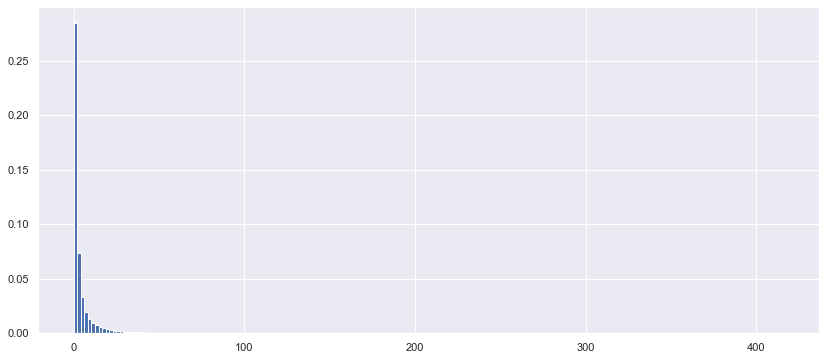

In [46]:
import matplotlib.pyplot as plt
import numpy as np

h = plt.hist(np.random.wald(5, 1, 100000), bins=200, density=True)

plt.show()